## About

このノートブックでは[全てのテーブルをjoinする](https://www.guruguru.science/competitions/12/discussions/b6b3dd96-1dc9-4e03-be99-6e4dcde75e61/)をベースにした特徴+LightGBMを用いたシンプルなベースラインを作成します。

In [1]:
!pip install jpholiday > /dev/null

## Libraries

In [2]:
import random
import os
import time

import jpholiday
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from contextlib import contextmanager
from pathlib import Path
from typing import Optional

from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [3]:
pd.set_option("max_columns", 60)

## Utils

In [4]:
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    msg = f"[{name}] done in {time.time() - t0:.0f} s"
    print(msg)
    
    
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [5]:
set_seed(1213)

## Data Loading

In [6]:
DATA_DIR = Path("../input/")

with timer("Load all data"):
    train = pd.read_csv(DATA_DIR / "train.csv")
    test = pd.read_csv(DATA_DIR / "test.csv")
    campaign = pd.read_csv(DATA_DIR / "campaign.csv")
    assets = pd.read_csv(DATA_DIR / "map_game_feed_native_video_assets.csv")
    video = pd.read_csv(DATA_DIR / "advertiser_video.csv")
    converted = pd.read_csv(DATA_DIR / "advertiser_converted_video.csv")
    sub = pd.read_csv(DATA_DIR / "atmaCup7__sample_submission.csv")

[Load all data] start
[Load all data] done in 6 s


In [7]:
# drop duplicated
# recommended at https://www.guruguru.science/competitions/12/discussions/dba321e8-c245-4d31-ada3-63aae1830295/
cols = ["mst_advertiser_video_id", "mst_game_feed_id", "mst_video_template_id"]
converted = converted[~converted[cols].duplicated(keep="last")]

## Merge all

In [8]:
# 参考: https://www.guruguru.science/competitions/12/discussions/b6b3dd96-1dc9-4e03-be99-6e4dcde75e61/
def merge_all(
    df: pd.DataFrame,
    campaign: pd.DataFrame,
    map_game_feed_native_video_assets: pd.DataFrame,
    advertiser_video: pd.DataFrame,
    advertiser_converted_video: pd.DataFrame,
) -> pd.DataFrame:
    # merge df and campaign
    res = pd.merge(
        df, campaign, left_on="campaign_id", right_on="id", how="left"
    ).drop(
        columns=["id", "mst_advertiser_id"]
    )  # remove campaign keys

    # merge res and map_game_feed_native_video_assets
    res = pd.merge(
        res,
        map_game_feed_native_video_assets,
        left_on="game_feed_id",
        right_on="mst_game_feed_id",
        how="left",
    ).drop(
        columns=["mst_game_feed_id"]
    )  # remove map_game_feed_native_video_assets keys

    # merge res and advertiser_video (horizontal case)
    horizontal = advertiser_video.copy()
    left_keys = ["horizontal_mst_advertiser_video_id", "advertiser_id"]
    right_keys = ["id", "mst_advertiser_id"]
    horizontal.columns = [
        f"horizontal_{c}" if c not in right_keys else c for c in horizontal.columns
    ]
    res = pd.merge(
        res, horizontal, left_on=left_keys, right_on=right_keys, how="left"
    ).drop(
        columns=right_keys
    )  # remove advertiser_video keys

    # merge res and advertiser_video (vertical case)
    vertical = advertiser_video.copy()
    left_keys = ["vertical_mst_advertiser_video_id", "advertiser_id"]
    right_keys = ["id", "mst_advertiser_id"]
    vertical.columns = [
        f"vertical_{c}" if c not in right_keys else c for c in vertical.columns
    ]
    res = pd.merge(
        res, vertical, left_on=left_keys, right_on=right_keys, how="left"
    ).drop(
        columns=right_keys
    )  # remove advertiser_video keys

    # merge res and advertiser_converted_video (horizontal case)
    left_keys = [
        "horizontal_mst_advertiser_video_id",
        "game_feed_id",
        "video_template_id",
    ]
    right_keys = [
        "mst_advertiser_video_id",
        "mst_game_feed_id",
        "mst_video_template_id",
    ]
    horizontal = advertiser_converted_video.copy()
    horizontal.columns = [
        f"horizontal_converted_{c}" if c not in right_keys else c
        for c in horizontal.columns
    ]
    res = pd.merge(
        res, horizontal, left_on=left_keys, right_on=right_keys, how="left"
    ).drop(
        columns=right_keys
    )  # remove advertiser_converted_video keys

    # merge res and advertiser_converted_video (vertical case)
    left_keys = [
        "vertical_mst_advertiser_video_id",
        "game_feed_id",
        "video_template_id",
    ]
    right_keys = [
        "mst_advertiser_video_id",
        "mst_game_feed_id",
        "mst_video_template_id",
    ]
    vertical = advertiser_converted_video.copy()
    vertical.columns = [
        f"vertical_converted_{c}" if c not in right_keys else c
        for c in vertical.columns
    ]
    res = pd.merge(
        res, vertical, left_on=left_keys, right_on=right_keys, how="left"
    ).drop(
        columns=right_keys
    )  # remove advertiser_converted_video keys

    return res

In [9]:
with timer("merge train"):
    train_merged = merge_all(train, campaign, assets, video, converted)
    
print(train_merged.shape)
print(train.shape)

[merge train] start
[merge train] done in 26 s
(1997595, 57)
(1997595, 35)


In [10]:
with timer("merge train"):
    test_merged = merge_all(test, campaign, assets, video, converted)
    
print(test_merged.shape)
print(test.shape)

[merge train] start
[merge train] done in 4 s
(390095, 52)
(390095, 30)


In [11]:
train_merged.head()

,request_id,imp_at,target,adnw_id,adspot_id,adspot_video_format_id,advertiser_id,app_id,auction_type_id,campaign_id,category_id,click_or_view_at,country_code,cv_at,first_login_interval,frequency,from_click,game_feed_asset_type_id,game_feed_id,game_template_id,header_bidding,is_interstitial,item_id,last_cv_interval,last_login_interval,last_paid_interval,login_frequency,max_login_interval,media_app_id,os,os_version,pos,uid,user_type_id,video_template_id,mst_advertiser_order_id,mst_user_type_id,horizontal_mst_advertiser_video_id,vertical_mst_advertiser_video_id,horizontal_duration,horizontal_width,horizontal_height,horizontal_file_size,vertical_duration,vertical_width,vertical_height,vertical_file_size,horizontal_converted_width,horizontal_converted_height,horizontal_converted_file_size,horizontal_converted_bitrate,horizontal_converted_rectangle_type,vertical_converted_width,vertical_converted_height,vertical_converted_file_size,vertical_converted_bitrate,vertical_converted_rectangle_type
0,ad6a7b7894f142d81a1e,2020-04-28 00:04:14.639000,0,4,1111,2.0,1b29c3959fc76425d130,efef8f05c293786ae95d,1.0,9ce932d55f27ed28f0e5,8497,2020-04-28 00:04:21.581000,JP,2020-04-29 00:04:05.618000,1490644.0,0,0,4,8371aa8713627e51023c,NaN,0.0,1.0,NaN,NaN,11320.0,29835.0,10.0,2607.0,NaN,1,13.3.1,0,30cfce348022c3812b3a,1,a96538aec6d5d90fd8d9,41afd03349de6b0db04e,35,d8444f94293d3f924090,NaN,16.0,1280.0,720.0,17332286.0,NaN,NaN,NaN,NaN,960.0,540.0,1441609.0,600000.0,horizontal,NaN,NaN,NaN,NaN,NaN
1,ac8453e4a93391812b78,2020-04-28 00:09:13.759000,0,28,1081,2.0,ba2bb260d8eccd0057a4,85518c203c727a6fcd6e,2.0,23f7cf2bddc97c599ac4,0,2020-04-29 01:59:08.418000,JP,2020-04-29 10:23:18.079000,790412.0,2,1,4,b28c75eda0294ffd7924,NaN,0.0,1.0,NaN,NaN,12589.0,159596.0,2.0,13540.0,c3292411366546db2194,2,9.0.0,1,4c28854cab6a85c37dab,2,297ade72d5f1e9ed6e2f,e51db809d3b307ca2ba7,37,0a7b673bfb4a5b291824,NaN,10.0,1280.0,720.0,31506417.0,NaN,NaN,NaN,NaN,540.0,960.0,1472404.0,1000000.0,vertical,NaN,NaN,NaN,NaN,NaN
2,4959adca0d9284e642c9,2020-04-28 00:09:14.708000,0,42,1123,3.0,0aaa2635cef6c96c7932,d01b84105c697315f36d,1.0,2dde952bf6521fac0b71,0,2020-04-28 00:09:29.655000,JP,2020-04-29 00:08:42.200000,1506105.0,0,0,4,200c99de864be1a88010,953c7610a60e2543c073,NaN,NaN,80525.0,906634.0,10254.0,156643.0,9.0,33725.0,07514730ff1e69100233,1,12.1.2,0,b35f0cd7210c4273489c,1,NaN,2d8d2a9908ccd080d343,35,20c203c3a36fe2b1e2cf,NaN,15.0,1920.0,1080.0,13520049.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,622c44ebc7cf591d046e,2020-04-28 00:10:40.291000,0,8,1113,2.0,1ed4e5bb950da757976a,c72faf7a97213d7e4c8c,1.0,1cbbcb2f33a045e5a09c,0,2020-04-28 00:10:50.270000,JP,2020-04-29 00:03:56.930000,184283.0,0,0,4,b98336c3d597f3d62202,NaN,NaN,1.0,NaN,NaN,39618.0,NaN,4.0,7377.0,84a2cff85228c12b0e6a,1,13.4.1,0,57dc1bf69be06dac416c,1,b5401899f2db8ce48d43,dac3c6d3688ba5db47d6,38,7865df44e1a50870d28f,NaN,30.0,1920.0,1080.0,38858983.0,NaN,NaN,NaN,NaN,540.0,960.0,2673046.0,600000.0,vertical,NaN,NaN,NaN,NaN,NaN
4,3093c6746ae6e35b9ad5,2020-04-28 00:11:45.895000,0,22,1061,NaN,d352ebd3462849796754,0376415068bf3e5b9e95,4.0,84095859da9cffce1c60,0,2020-05-05 17:39:43.537000,JP,2020-05-05 23:56:19.105000,1999495.0,2,1,2,84ed0ed356eb339c6eaa,5f60f2a2df7efc8f339e,1.0,0.0,NaN,NaN,35652.0,1566749.0,5.0,164759.0,2fd1c330d5a47edc039b,1,12.4.5,0,7ca7b54b97093b084027,1,NaN,5a849d8194137b79cc35,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test_merged.head()

,request_id,imp_at,adnw_id,adspot_id,adspot_video_format_id,advertiser_id,app_id,auction_type_id,campaign_id,category_id,country_code,first_login_interval,frequency,from_click,game_feed_asset_type_id,game_feed_id,game_template_id,header_bidding,is_interstitial,item_id,last_login_interval,login_frequency,max_login_interval,media_app_id,os,os_version,pos,uid,user_type_id,video_template_id,mst_advertiser_order_id,mst_user_type_id,horizontal_mst_advertiser_video_id,vertical_mst_advertiser_video_id,horizontal_duration,horizontal_width,horizontal_height,horizontal_file_size,vertical_duration,vertical_width,vertical_height,vertical_file_size,horizontal_converted_width,horizontal_converted_height,horizontal_converted_file_size,horizontal_converted_bitrate,horizontal_converted_rectangle_type,vertical_converted_width,vertical_converted_height,vertical_converted_file_size,vertical_converted_bitrate,vertical_converted_rectangle_type
0,9747ce53a3cb6b71083d,2020-06-27 00:04:19.064000,26,1069,3.0,f18c256a442a34e0b415,e2e4c7033fd8b771cbc9,1.0,68bf8df385e56d7c7224,0,JP,125284.0,2,0,4,8b94124cb457e78df93c,NaN,NaN,0.0,NaN,18279.0,1,31684.0,1dd7e16fec6017fdc4cc,1,13.5.1,1,d88dff8c67cbca5063b6,1,NaN,5757d8e3d1afcb839850,38,8401391ff2c904dbfae3,NaN,18.0,1280.0,720.0,23513706.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,688ca2024829c392a509,2020-06-27 00:11:59.392000,28,1081,1.0,1ed4e5bb950da757976a,39b1641c9aee267d6c8c,2.0,0b4017d3f3113de38ba6,0,JP,489271.0,0,1,4,63096db91899bdcb91f3,NaN,0.0,1.0,NaN,12665.0,1,224419.0,08c200079eb692fd93b8,2,8.0.0,1,ecb26d89e786f4710c62,2,69b22b4400be9d91e6cc,dac3c6d3688ba5db47d6,36,54caefd390e14145e483,NaN,30.0,1920.0,1080.0,38819702.0,NaN,NaN,NaN,NaN,540.0,960.0,2673654.0,600000.0,vertical,NaN,NaN,NaN,NaN,NaN
2,b0b8044a2428958ac17b,2020-06-27 00:14:09.341000,28,1081,2.0,5b843a28e245912f51ca,483c546765bd610ab0e3,2.0,985dfa150be554b1714d,0,US,390685.0,1,1,4,1951ab4e1ad406da7f95,NaN,0.0,1.0,NaN,7521.0,5,16301.0,0860cd60ba0f3eef24d8,2,10.0.0,1,85e9de3b175557cf577f,2,297ade72d5f1e9ed6e2f,90360f865a832b209077,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6b9bb6e4f70cad3a629a,2020-06-27 00:18:08.399000,27,1073,3.0,1ed4e5bb950da757976a,65235845da2e07e67145,1.0,b3857c6735bc69ea932d,0,JP,76181.0,0,1,4,5e9fa5bdd5eb5ebbcecd,953c7610a60e2543c073,0.0,NaN,84033.0,64583.0,8,2701.0,43b7a628b6db774cc045,2,5.0.2,0,0bba4196f93ca1cdbc22,2,NaN,dac3c6d3688ba5db47d6,38,b249141eabd869bc4476,NaN,30.0,1920.0,1080.0,38155214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07234a3c7389cc36bc0e,2020-06-27 00:23:18.583000,26,1069,3.0,1a71092d4f938588d1fd,c542bacba91a6b4b595f,1.0,8da6c586bd1089956477,8305,JP,244134.0,2,0,4,45884361e5d2f0985572,NaN,NaN,0.0,NaN,35453.0,1,53622.0,d0eab9db52e426309036,2,9,1,947fc17776732f10cc9e,2,NaN,e4791b95f5c523882b59,38,35329f1b6ac0b827f3c3,NaN,6.0,1280.0,720.0,11455389.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Engineering

カテゴリ変数をラベルエンコーディングしたり、時間に関する特徴を作成したりします。

In [13]:
target_col = "target"
only_train_columns = set(train_merged.columns) - set(test_merged.columns) - {target_col}
only_train_columns

{'click_or_view_at', 'cv_at', 'last_cv_interval', 'last_paid_interval'}

trainにしかないカラムが一部のあるので削除します。

In [14]:
train_merged.drop(list(only_train_columns), axis=1, inplace=True)

### datetime related features

時間に関する特徴を作成します。

In [15]:
train_merged["imp_at"] = pd.to_datetime(train_merged["imp_at"])
test_merged["imp_at"] = pd.to_datetime(test_merged["imp_at"])

with timer("process time features"):
    train_merged["dayofweek"] = train_merged.imp_at.dt.dayofweek
    test_merged["dayofweek"] = test_merged.imp_at.dt.dayofweek

    train_merged["hour"] = train_merged.imp_at.dt.hour
    test_merged["hour"] = test_merged.imp_at.dt.hour

    train_merged["minute"] = train_merged.imp_at.dt.minute
    test_merged["minute"] = test_merged.imp_at.dt.minute

[process time features] start
[process time features] done in 0 s


In [16]:
with timer("process holiday"):
    dts_map = {}
    train_dates = train_merged.imp_at.dt.date
    test_dates = test_merged.imp_at.dt.date
    for dt in train_dates:
        dts_map[dt] = jpholiday.is_holiday(dt)

    for dt in test_dates:
        dts_map[dt] = jpholiday.is_holiday(dt)

    # 祝日
    train_merged["holiday"] = train_merged.imp_at.dt.date.map(dts_map)
    test_merged["holiday"] = test_merged.imp_at.dt.date.map(dts_map)
    
    train_merged["holiday"] = train_merged["holiday"].astype(int)
    test_merged["holiday"] = test_merged["holiday"].astype(int)

    # 祝休日
    train_merged["is_off_day"] = train_merged["dayofweek"].map(lambda x: 1 if x in [5, 6] else 0) + train_merged["holiday"]
    test_merged["is_off_day"] = test_merged["dayofweek"].map(lambda x: 1 if x in [5, 6] else 0) + test_merged["holiday"]

[process holiday] start
[process holiday] done in 83 s


### categoricals

カテゴリ変数をラベルエンコーディングします。その際、trainにしか出てこない値/testにしか出てこない値があるカラムが多数あるため、そのような値は全て`'other'`というクラスに押し込めて処理することにします。

In [17]:
def get_non_overlapping(train: pd.DataFrame, test: pd.DataFrame, column: str):
    """train/testにしか出てこない値を調べる"""
    only_in_train = set(train[column].unique()) - set(test[column].unique())
    only_in_test = set(test[column].unique()) - set(train[column].unique())
    non_overlapping = only_in_train.union(only_in_test)
    return non_overlapping


def category2num(train: pd.DataFrame, test: pd.DataFrame, columns: list):
    train_ = train.copy()
    test_ = test.copy()
    for column in columns:
        non_overlapping = get_non_overlapping(train, test, column)
        try:
            if train[column].dtype == np.dtype("O"):
                # dtypeがobjectなら欠損は'missing' クラスにする
                train_[column] = train[column].fillna("missing")
                test_[column] = test[column].fillna("missing")
                train_[column] = train_[column].map(lambda x: x if x not in non_overlapping else "other")
                test_[column] = test_[column].map(lambda x: x if x not in non_overlapping else "other")
            else:
                # dtypeがint/floatなら欠損は'-1'とする
                train_[column] = train[column].fillna(-1)
                test_[column] = test[column].fillna(-1)
                train_[column] = train_[column].map(lambda x: x if x not in non_overlapping else -2)
                test_[column] = test_[column].map(lambda x: x if x not in non_overlapping else -2)

            le = LabelEncoder()
            concatenated = pd.concat([train_, test_], axis=0).reset_index(drop=True)
            le.fit(concatenated[column])
            train_[column] = le.transform(train_[column])
            test_[column] = le.transform(test_[column])
        except Exception:
            import pdb
            pdb.set_trace()
    return train_, test_

In [18]:
with timer("process categoricals"):
    columns = ["adspot_id", "adspot_video_format_id", "advertiser_id", "app_id", 
               "auction_type_id", "campaign_id", "category_id", "country_code", "game_feed_asset_type_id",
               "game_feed_id", "game_template_id", "item_id", "media_app_id", "os", "uid", "user_type_id", "video_template_id",
               "mst_advertiser_order_id", "mst_user_type_id", "horizontal_mst_advertiser_video_id", 
               "vertical_mst_advertiser_video_id", "horizontal_converted_rectangle_type", "vertical_converted_rectangle_type"]
    train_merged, test_merged = category2num(train_merged, test_merged, columns)

[process categoricals] start
[process categoricals] done in 49 s


In [19]:
train_merged.head()

,request_id,imp_at,target,adnw_id,adspot_id,adspot_video_format_id,advertiser_id,app_id,auction_type_id,campaign_id,category_id,country_code,first_login_interval,frequency,from_click,game_feed_asset_type_id,game_feed_id,game_template_id,header_bidding,is_interstitial,item_id,last_login_interval,login_frequency,max_login_interval,media_app_id,os,os_version,pos,uid,user_type_id,video_template_id,mst_advertiser_order_id,mst_user_type_id,horizontal_mst_advertiser_video_id,vertical_mst_advertiser_video_id,horizontal_duration,horizontal_width,horizontal_height,horizontal_file_size,vertical_duration,vertical_width,vertical_height,vertical_file_size,horizontal_converted_width,horizontal_converted_height,horizontal_converted_file_size,horizontal_converted_bitrate,horizontal_converted_rectangle_type,vertical_converted_width,vertical_converted_height,vertical_converted_file_size,vertical_converted_bitrate,vertical_converted_rectangle_type,dayofweek,hour,minute,holiday,is_off_day
0,ad6a7b7894f142d81a1e,2020-04-28 00:04:14.639,0,4,47,2,14,5653,1,256,42,0,1490644.0,0,0,2,699,66,0.0,1.0,1,11320.0,10.0,2607.0,4780,0,13.3.1,0,108518,0,3,25,1,531,2,16.0,1280.0,720.0,17332286.0,NaN,NaN,NaN,NaN,960.0,540.0,1441609.0,600000.0,0,NaN,NaN,NaN,NaN,0,1,0,4,0,0
1,ac8453e4a93391812b78,2020-04-28 00:09:13.759,0,28,37,2,86,3127,2,56,1,0,790412.0,2,1,2,1347,66,0.0,1.0,1,12589.0,2.0,13540.0,3645,1,9.0.0,1,108518,1,1,115,3,627,2,10.0,1280.0,720.0,31506417.0,NaN,NaN,NaN,NaN,540.0,960.0,1472404.0,1000000.0,2,NaN,NaN,NaN,NaN,0,1,0,9,0,0
2,4959adca0d9284e642c9,2020-04-28 00:09:14.708,0,42,55,3,4,4947,1,76,1,0,1506105.0,0,0,2,1347,33,NaN,NaN,0,10254.0,9.0,33725.0,121,0,12.1.2,0,108518,0,6,17,1,627,2,15.0,1920.0,1080.0,13520049.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0,1,0,9,0,0
3,622c44ebc7cf591d046e,2020-04-28 00:10:40.291,0,8,48,2,15,4725,1,47,1,0,184283.0,0,0,2,1347,66,NaN,1.0,1,39618.0,4.0,7377.0,2466,0,13.4.1,0,108518,0,4,112,4,627,2,30.0,1920.0,1080.0,38858983.0,NaN,NaN,NaN,NaN,540.0,960.0,2673046.0,600000.0,2,NaN,NaN,NaN,NaN,0,1,0,10,0,0
4,3093c6746ae6e35b9ad5,2020-04-28 00:11:45.895,0,22,22,0,95,67,3,214,1,0,1999495.0,2,1,1,709,67,1.0,0.0,1,35652.0,5.0,164759.0,867,0,12.4.5,0,108518,0,6,38,1,626,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0,1,0,11,0,0


In [20]:
test_merged.head()

,request_id,imp_at,adnw_id,adspot_id,adspot_video_format_id,advertiser_id,app_id,auction_type_id,campaign_id,category_id,country_code,first_login_interval,frequency,from_click,game_feed_asset_type_id,game_feed_id,game_template_id,header_bidding,is_interstitial,item_id,last_login_interval,login_frequency,max_login_interval,media_app_id,os,os_version,pos,uid,user_type_id,video_template_id,mst_advertiser_order_id,mst_user_type_id,horizontal_mst_advertiser_video_id,vertical_mst_advertiser_video_id,horizontal_duration,horizontal_width,horizontal_height,horizontal_file_size,vertical_duration,vertical_width,vertical_height,vertical_file_size,horizontal_converted_width,horizontal_converted_height,horizontal_converted_file_size,horizontal_converted_bitrate,horizontal_converted_rectangle_type,vertical_converted_width,vertical_converted_height,vertical_converted_file_size,vertical_converted_bitrate,vertical_converted_rectangle_type,dayofweek,hour,minute,holiday,is_off_day
0,9747ce53a3cb6b71083d,2020-06-27 00:04:19.064,26,28,3,110,5370,1,170,1,0,125284.0,2,0,2,750,66,NaN,0.0,1,18279.0,1,31684.0,531,0,13.5.1,1,108518,0,6,35,4,334,2,18.0,1280.0,720.0,23513706.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0,5,0,4,0,1
1,688ca2024829c392a509,2020-06-27 00:11:59.392,28,37,1,15,1333,2,18,1,0,489271.0,0,1,2,531,66,0.0,1.0,1,12665.0,1,224419.0,151,1,8.0.0,1,108518,1,2,112,2,199,2,30.0,1920.0,1080.0,38819702.0,NaN,NaN,NaN,NaN,540.0,960.0,2673654.0,600000.0,2,NaN,NaN,NaN,NaN,0,5,0,11,0,1
2,b0b8044a2428958ac17b,2020-06-27 00:14:09.341,28,37,2,36,1687,2,247,1,1,390685.0,1,1,2,122,66,0.0,1.0,1,7521.0,5,16301.0,146,1,10.0.0,1,108518,1,1,60,3,626,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0,5,0,14,0,1
3,6b9bb6e4f70cad3a629a,2020-06-27 00:18:08.399,27,31,3,15,2379,1,297,1,0,76181.0,0,1,2,1347,33,0.0,NaN,0,64583.0,8,2701.0,1238,1,5.0.2,0,108518,1,6,112,4,627,2,30.0,1920.0,1080.0,38155214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0,5,0,18,0,1
4,07234a3c7389cc36bc0e,2020-06-27 00:23:18.583,26,28,3,12,4682,1,233,33,0,244134.0,2,0,2,1347,66,NaN,0.0,1,35453.0,1,53622.0,3908,1,9,1,108518,1,6,114,4,627,2,6.0,1280.0,720.0,11455389.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0,5,0,23,0,1


### numericals

`frequency`は10を超えると一気に頻度が減るため10以上は全て10とします。
また、`horizontal_`/`vertical_`系でファイルサイズやdurationなどは統一したカラムに直しておきます。

In [21]:
with timer("process numericals"):
    # frequency
    train_merged["frequency"] = train_merged["frequency"].map(lambda x: x if x < 10 else 10)
    test_merged["frequency"] = test_merged["frequency"].map(lambda x: x if x < 10 else 10)
    
    # duration
    train_merged["duration"] = train_merged["vertical_duration"].fillna(0) + train_merged["horizontal_duration"].fillna(0)
    train_merged.drop(["vertical_duration", "horizontal_duration"], axis=1, inplace=True)

    test_merged["duration"] = test_merged["vertical_duration"].fillna(0) + test_merged["horizontal_duration"].fillna(0)
    test_merged.drop(["vertical_duration", "horizontal_duration"], axis=1, inplace=True)
    
    # filesize
    train_merged["filesize"] = train_merged["vertical_file_size"].fillna(0) + train_merged["horizontal_file_size"].fillna(0)
    train_merged.drop(["vertical_file_size", "horizontal_file_size"], axis=1, inplace=True)

    test_merged["filesize"] = test_merged["vertical_file_size"].fillna(0) + test_merged["horizontal_file_size"].fillna(0)
    test_merged.drop(["vertical_file_size", "horizontal_file_size"], axis=1, inplace=True)
    
    # converted filesize
    train_merged["converted_filesize"] = train_merged["vertical_converted_file_size"].fillna(0.0) + train_merged["horizontal_converted_file_size"].fillna(0)
    train_merged.drop(["vertical_converted_file_size", "horizontal_converted_file_size"], axis=1, inplace=True)

    test_merged["converted_filesize"] = test_merged["horizontal_converted_file_size"].fillna(0.0) + test_merged["vertical_converted_file_size"].fillna(0)
    test_merged.drop(["vertical_converted_file_size", "horizontal_converted_file_size"], axis=1, inplace=True)
    
    # bitrate
    train_merged["bitrate"] = train_merged["vertical_converted_bitrate"].fillna(0) + test_merged["horizontal_converted_bitrate"].fillna(0)
    train_merged.drop(["vertical_converted_bitrate", "horizontal_converted_bitrate"], axis=1, inplace=True)

    test_merged["bitrate"] = test_merged["vertical_converted_bitrate"].fillna(0) + test_merged["horizontal_converted_bitrate"].fillna(0)
    test_merged.drop(["vertical_converted_bitrate", "horizontal_converted_bitrate"], axis=1, inplace=True)

[process numericals] start
[process numericals] done in 2 s


`os_version`はtrain/testの乖離が激しいため削除します。

In [22]:
train_merged.drop("os_version", axis=1, inplace=True)
test_merged.drop("os_version", axis=1, inplace=True)

In [23]:
train_merged.head()

,request_id,imp_at,target,adnw_id,adspot_id,adspot_video_format_id,advertiser_id,app_id,auction_type_id,campaign_id,category_id,country_code,first_login_interval,frequency,from_click,game_feed_asset_type_id,game_feed_id,game_template_id,header_bidding,is_interstitial,item_id,last_login_interval,login_frequency,max_login_interval,media_app_id,os,pos,uid,user_type_id,video_template_id,mst_advertiser_order_id,mst_user_type_id,horizontal_mst_advertiser_video_id,vertical_mst_advertiser_video_id,horizontal_width,horizontal_height,vertical_width,vertical_height,horizontal_converted_width,horizontal_converted_height,horizontal_converted_rectangle_type,vertical_converted_width,vertical_converted_height,vertical_converted_rectangle_type,dayofweek,hour,minute,holiday,is_off_day,duration,filesize,converted_filesize,bitrate
0,ad6a7b7894f142d81a1e,2020-04-28 00:04:14.639,0,4,47,2,14,5653,1,256,42,0,1490644.0,0,0,2,699,66,0.0,1.0,1,11320.0,10.0,2607.0,4780,0,0,108518,0,3,25,1,531,2,1280.0,720.0,NaN,NaN,960.0,540.0,0,NaN,NaN,0,1,0,4,0,0,16.0,17332286.0,1441609.0,0.0
1,ac8453e4a93391812b78,2020-04-28 00:09:13.759,0,28,37,2,86,3127,2,56,1,0,790412.0,2,1,2,1347,66,0.0,1.0,1,12589.0,2.0,13540.0,3645,1,1,108518,1,1,115,3,627,2,1280.0,720.0,NaN,NaN,540.0,960.0,2,NaN,NaN,0,1,0,9,0,0,10.0,31506417.0,1472404.0,600000.0
2,4959adca0d9284e642c9,2020-04-28 00:09:14.708,0,42,55,3,4,4947,1,76,1,0,1506105.0,0,0,2,1347,33,NaN,NaN,0,10254.0,9.0,33725.0,121,0,0,108518,0,6,17,1,627,2,1920.0,1080.0,NaN,NaN,NaN,NaN,1,NaN,NaN,0,1,0,9,0,0,15.0,13520049.0,0.0,0.0
3,622c44ebc7cf591d046e,2020-04-28 00:10:40.291,0,8,48,2,15,4725,1,47,1,0,184283.0,0,0,2,1347,66,NaN,1.0,1,39618.0,4.0,7377.0,2466,0,0,108518,0,4,112,4,627,2,1920.0,1080.0,NaN,NaN,540.0,960.0,2,NaN,NaN,0,1,0,10,0,0,30.0,38858983.0,2673046.0,0.0
4,3093c6746ae6e35b9ad5,2020-04-28 00:11:45.895,0,22,22,0,95,67,3,214,1,0,1999495.0,2,1,1,709,67,1.0,0.0,1,35652.0,5.0,164759.0,867,0,0,108518,0,6,38,1,626,2,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0,1,0,11,0,0,0.0,0.0,0.0,0.0


In [24]:
test_merged.head()

,request_id,imp_at,adnw_id,adspot_id,adspot_video_format_id,advertiser_id,app_id,auction_type_id,campaign_id,category_id,country_code,first_login_interval,frequency,from_click,game_feed_asset_type_id,game_feed_id,game_template_id,header_bidding,is_interstitial,item_id,last_login_interval,login_frequency,max_login_interval,media_app_id,os,pos,uid,user_type_id,video_template_id,mst_advertiser_order_id,mst_user_type_id,horizontal_mst_advertiser_video_id,vertical_mst_advertiser_video_id,horizontal_width,horizontal_height,vertical_width,vertical_height,horizontal_converted_width,horizontal_converted_height,horizontal_converted_rectangle_type,vertical_converted_width,vertical_converted_height,vertical_converted_rectangle_type,dayofweek,hour,minute,holiday,is_off_day,duration,filesize,converted_filesize,bitrate
0,9747ce53a3cb6b71083d,2020-06-27 00:04:19.064,26,28,3,110,5370,1,170,1,0,125284.0,2,0,2,750,66,NaN,0.0,1,18279.0,1,31684.0,531,0,1,108518,0,6,35,4,334,2,1280.0,720.0,NaN,NaN,NaN,NaN,1,NaN,NaN,0,5,0,4,0,1,18.0,23513706.0,0.0,0.0
1,688ca2024829c392a509,2020-06-27 00:11:59.392,28,37,1,15,1333,2,18,1,0,489271.0,0,1,2,531,66,0.0,1.0,1,12665.0,1,224419.0,151,1,1,108518,1,2,112,2,199,2,1920.0,1080.0,NaN,NaN,540.0,960.0,2,NaN,NaN,0,5,0,11,0,1,30.0,38819702.0,2673654.0,600000.0
2,b0b8044a2428958ac17b,2020-06-27 00:14:09.341,28,37,2,36,1687,2,247,1,1,390685.0,1,1,2,122,66,0.0,1.0,1,7521.0,5,16301.0,146,1,1,108518,1,1,60,3,626,2,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0,5,0,14,0,1,0.0,0.0,0.0,0.0
3,6b9bb6e4f70cad3a629a,2020-06-27 00:18:08.399,27,31,3,15,2379,1,297,1,0,76181.0,0,1,2,1347,33,0.0,NaN,0,64583.0,8,2701.0,1238,1,0,108518,1,6,112,4,627,2,1920.0,1080.0,NaN,NaN,NaN,NaN,1,NaN,NaN,0,5,0,18,0,1,30.0,38155214.0,0.0,0.0
4,07234a3c7389cc36bc0e,2020-06-27 00:23:18.583,26,28,3,12,4682,1,233,33,0,244134.0,2,0,2,1347,66,NaN,0.0,1,35453.0,1,53622.0,3908,1,1,108518,1,6,114,4,627,2,1280.0,720.0,NaN,NaN,NaN,NaN,1,NaN,NaN,0,5,0,23,0,1,6.0,11455389.0,0.0,0.0


## KFold training

In [25]:
class TreeModel:
    """LGB/XGBのAPIを統一したwrapper"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weight: Optional[np.ndarray] = None,
              val_weight: Optional[np.ndarray] = None,
              train_params: dict = {}):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        else:
            raise NotImplementedError
        return self.model

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(X_DM)  # type: ignore
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        else:
            raise NotImplementedError

In [26]:
def lgb_average_precision_score(
        preds: np.ndarray, data: lgb.Dataset):
    """Average precision scoreのLightGBM用メトリック"""
    label = data.get_label()
    score = average_precision_score(y_true=label, y_score=preds)
    
    return "pr_auc", score, True

In [28]:
# メインループ
use_cols = list(train_merged.columns)[3:]

feature_importances = pd.DataFrame()
result = {}
oof = pd.DataFrame()
preds = np.zeros(len(test_merged))
scores = 0.0

skf = StratifiedKFold(n_splits=5, random_state=1213, shuffle=True)
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_merged, train_merged[target_col])):
    print("*" * 100)
    print(f"Fold: {fold}")
    
    X_trn = train_merged.loc[trn_idx, use_cols].reset_index(drop=True)
    X_val = train_merged.loc[val_idx, use_cols].reset_index(drop=True)
    
    y_trn = train_merged.loc[trn_idx, target_col].reset_index(drop=True)
    y_val = train_merged.loc[val_idx, target_col].reset_index(drop=True)
    
    model = TreeModel(model_type="lgb")
    params = {
        "objective": "binary",
        "boosting": "gbdt",
        "learning_rate": 0.1,
        "seed": 1213,
        "first_metric_only": True
    }
    with timer("Model training"):
        model.train(params=params,
                    X_train=X_trn,
                    y_train=y_trn.values,
                    X_val=X_val,
                    y_val=y_val.values,
                    train_params={
                        "num_boost_round": 20000,
                        "early_stopping_rounds": 100,
                        "verbose_eval": 100,
                        "feval": lgb_average_precision_score
                    })
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = model.feature_names_
    fi_tmp["importance"] = model.feature_importances_
    fi_tmp["fold"] = fold
    feature_importances = feature_importances.append(fi_tmp)
    
    val_pred = model.predict(X_val)
    score = average_precision_score(y_true=y_val, y_score=val_pred)
    scores += score / 5
    
    print(f"score: {score:.5f}")
    
    oof = oof.append(pd.DataFrame({"request_id": train_merged.loc[val_idx, "request_id"], "preds": val_pred}))
    
    pred = model.predict(test_merged[use_cols])
    preds += pred / 5

****************************************************************************************************
Fold: 0
[Model training] start
[LightGBM] [Info] Number of positive: 52392, number of negative: 1545684
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 1598076, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032784 -> initscore=-3.384468
[LightGBM] [Info] Start training from score -3.384468
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.105227	training's pr_auc: 0.23966	valid_1's binary_logloss: 0.106398	valid_1's pr_auc: 0.22669
[200]	training's binary_logloss: 0.102409	training's pr_auc: 0.264892	valid_1's binary_logloss: 0.105447	valid_

In [29]:
oof

,request_id,preds
3,622c44ebc7cf591d046e,0.004172
6,9db8f5a8c4db2d464e7c,0.001069
13,f413d31ca46631bd8dd0,0.000130
23,2cd5c8d48829ed7d534b,0.004919
47,91fd5d035783dde78fd9,0.004692
...,...,...
1997567,4aedfb781d4371c93c2f,0.001576
1997575,cdcfdb9a0db9fb25fb1a,0.001088
1997583,89e544c5611989dedd59,0.005643
1997585,73339be0558f416b0ecc,0.001596


In [30]:
target_df = train_merged[["request_id", "target"]]
target_df = target_df.merge(oof, on="request_id")
target_df

,request_id,target,preds
0,ad6a7b7894f142d81a1e,0,0.132741
1,ac8453e4a93391812b78,0,0.072777
2,4959adca0d9284e642c9,0,0.116721
3,622c44ebc7cf591d046e,0,0.004172
4,3093c6746ae6e35b9ad5,0,0.088387
...,...,...,...
1997590,2e84117b770e59ae7262,0,0.190520
1997591,6abe6c2f733abe6111a8,0,0.000672
1997592,84a22646e56087a71691,0,0.005110
1997593,bd2a2dbe0a8dd27d5a89,0,0.002583


In [31]:
score = average_precision_score(y_true=target_df["target"], y_score=target_df["preds"])
print(f"score: {score:.5f}")

score: 0.23325


## Results

In [33]:
feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False)

feature
mst_user_type_id                       260833.056234
advertiser_id                           96262.418780
mst_advertiser_order_id                 69503.084244
campaign_id                             61435.884176
last_login_interval                     58493.619682
first_login_interval                    32252.203100
max_login_interval                      32115.554815
login_frequency                         19641.786070
game_feed_id                            18832.711903
duration                                13537.186727
media_app_id                            13519.492739
app_id                                  13056.249007
user_type_id                            12935.794101
from_click                              12126.255312
filesize                                11958.572727
minute                                  10911.500091
bitrate                                 10260.484400
uid                                      9691.465605
hour                                  

In [34]:
output_dir = Path("../outputs/LGBM_Baseline")
output_dir.mkdir(exist_ok=True, parents=True)

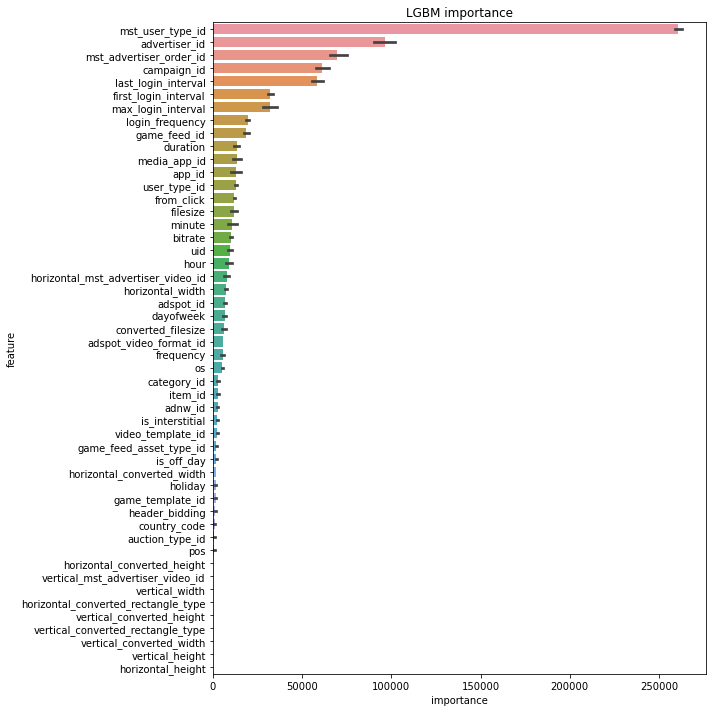

In [36]:
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("LGBM importance")
plt.tight_layout()
plt.savefig(output_dir / f"feature_importance_lgb.png")

In [37]:
oof.to_csv(output_dir / "oof.csv", index=False)

In [38]:
sub["target"] = preds
sub.to_csv(output_dir / "submission.csv", index=False)
sub.head()

,target
0,0.000695
1,0.001453
2,0.007650
3,0.004006
4,0.001608
